In [34]:

%matplotlib inline
%run 'bin/notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *



# ------------------------------------------------------------------------------
#
# absolute utilization: number of core hours per activity
# relative utilization: percentage of total pilot core hours
#
ABSOLUTE = False


# ------------------------------------------------------------------------------
#
# pilot and unit activities: core hours are derived by multiplying the
# respective time durations with pilot size / unit size.  The 'idle' utilization
# and the 'agent' utilization are derived separately.
#
# Note that durations should add up to the `x_total` generations to ensure
# accounting for the complete unit/pilot utilization.
#
PILOT_DURATIONS = {
        'p_total'     : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }],

        'p_boot'      : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'sync_rel'         }],
        'p_setup_1'   : [{STATE: None,            EVENT: 'sync_rel'         },
                         {STATE: None,            EVENT: 'orte_dvm_start'   }],
        'p_orte'      : [{STATE: None,            EVENT: 'orte_dvm_start'   },
                         {STATE: None,            EVENT: 'orte_dvm_ok'      }],
        'p_setup_2'   : [{STATE: None,            EVENT: 'orte_dvm_ok'      },
                         {STATE: PMGR_ACTIVE,     EVENT: 'state'            }],
        'p_uexec'     : [{STATE: PMGR_ACTIVE,     EVENT: 'state'            },
                         {STATE: None,            EVENT: 'cmd'              }],
        'p_term'      : [{STATE: None,            EVENT: 'cmd'              },
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }]}

UNIT_DURATIONS = {
        'u_total'     : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: None,            EVENT: 'unschedule_stop'  }],

        'u_equeue'    : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: AGENT_EXECUTING, EVENT: 'state'            }],
        'u_eprep'     : [{STATE: AGENT_EXECUTING, EVENT: 'state'            },
                         {STATE: None,            EVENT: 'exec_start'       }],
        'u_exec_rp'   : [{STATE: None,            EVENT: 'exec_start'       },
                         {STATE: None,            EVENT: 'cu_start'         }],
        'u_exec_cu'   : [{STATE: None,            EVENT: 'cu_start'         },
                         {STATE: None,            EVENT: 'cu_exec_start'    }],
        'u_exec_orte' : [{STATE: None,            EVENT: 'cu_exec_start'    },
                         {STATE: None,            EVENT: 'app_start'        }],
        'u_exec_app'  : [{STATE: None,            EVENT: 'app_start'        },
                         {STATE: None,            EVENT: 'app_stop'         }],
        'u_unschedule': [{STATE: None,            EVENT: 'app_stop'         },
                         {STATE: None,            EVENT: 'unschedule_stop'  }]}

DERIVED_DURATIONS = ['p_agent', 'p_idle', 'p_setup']

TRANSLATE_KEYS    = {
                     'p_agent'     : '* agent nodes',
                     'p_boot'      : '* pilot bootstrap',
                     'p_setup'     : '* pilot setup',
                     'p_orte'      : '* orte  setup',
                     'p_term'      : '* pilot termination',
                     'p_idle'      : '* pilot idle',

                     'u_equeue'    : 'SchedulerQueing CU',
                     'u_eprep'     : '* CU preparation',
                     'u_exec_rp'   : 'Executor Spawning CU',
                     'u_exec_cu'   : 'OS Spawning CU',
                     'u_exec_orte' : '* CU execution (ORTE)',
                     'u_exec_app'  : 'Executable Executing',
                     'u_unschedule': '? Scheduler Unscheduling',
    
                     'rp_overhead' : 'RP Overhead', 
                     'rp_busy'     : 'Workload Execution',
                     'rp_idle'     : 'RP Idle',
                     'rp_orte'     : 'RP ORTE', 
                     'rp_scheduler': 'RP Scheduler'
                    }

  # # Durations sub-component level
  # df['Scheduler Scheduling']   = df['Scheduler Stops Schedule']   - df['Scheduler Starts Schedule']
  # df['Scheduler Queuing CU']   = df['Executor Starts']            - df['Scheduler Queues CU']
  # df['Executor Starting']      = df['Executor Starts Mkdir']      - df['Executor Starts']
  # df['Executor Making Dir']    = df['Executor Stops Mkdir']       - df['Executor Starts Mkdir']
  # df['Executor Spawning CU']   = df['OS Accepts Spawned CU']      - df['Executor Spawns CU']
  # df['OS Spawning CU']         = df['OS Spawns CU']               - df['OS Accepts Spawned CU']
  # df['CU Changing Dir']        = df['CU Changes Dir']             - df['OS Spawns CU']
  # df['CU Pre-executing']       = df['CU Stops Pre-execute']       - df['CU Starts Pre-execute']
  # df['CU Spawning Executable'] = df['Executable Starts']          - df['CU Spawns Executable']
  # df['Executable Executing']   = df['Executable Stops']           - df['Executable Starts']
  # df['CU Post-executing']      = df['CU Stops Post-execute']      - df['CU Starts Post-execute']
  # df['Executor Stopping']      = df['Executor Stops']             - df['CU Stops Post-execute']
  # df['Scheduler Unscheduling'] = df['Scheduler Stops Unschedule'] - df['Scheduler Starts Unschedule']


# there must be a better way to do this...
ORDERED_KEYS      = [
                     'p_boot',
                     'p_setup',
                     'p_orte',
                     'u_equeue',
                     'u_eprep',
                     'u_exec_rp',
                     'u_exec_cu',
                     'u_exec_orte',
                     'u_exec_app',
                     'u_unschedule',
                     'p_idle',
                     'p_term',
                     'p_agent',
                     ]

In [2]:
SUM_KEYS_1 = {'rp_scheduler' : ['u_equeue', 'u_unschedule'], 
              'rp_orte'      : ['p_orte', 'u_exec_orte'], 
              'rp_overhead'  : ['p_agent', 'p_boot', 'p_setup', 'p_term', 'u_eprep', 'u_exec_rp', 'u_exec_cu'], 
              'rp_idle'      : ['p_idle'], 
              'rp_busy'      : ['u_exec_app']
             }
ORDERED_KEYS_1 = ['rp_overhead', 'rp_scheduler', 'rp_orte', 'rp_busy', 'rp_idle']

SUM_KEYS_2 = {'rp_overhead'  : ['p_agent', 'p_boot', 'p_setup', 'p_orte', 'p_term', 'u_equeue', 'u_eprep', 'u_exec_rp', 'u_exec_cu', 'u_exec_orte', 'u_unschedule'], 
              'rp_idle'      : ['p_idle'], 
              'rp_busy'      : ['u_exec_app']
             }
ORDERED_KEYS_2 = ['rp_overhead', 'rp_busy', 'rp_idle']


In [3]:
    sources     = sys.argv[1:]
    utilization = dict()    # dict of contributions to utilization
    sids        = list()    # used for labels

    if True:
        ws_path = '../rawdata/weak_scaling_synapse_titan/optimized'
        ss_path = '../rawdata/strong_scaling_synapse_titan'
        t_path  = '../rawdata/tests'
        sources = [
              # '%s/rp.session.thinkie.merzky.017494.0007'    % t_path,

                '%s/ws_syn_titan_32_32_1024_60_1.0'           % ws_path,
           #    '%s/ws_syn_titan_32_32_1024_60_1.1'           % ws_path,
                '%s/ws_syn_titan_64_32_2048_60_2.0'           % ws_path,
           #    '%s/ws_syn_titan_64_32_2048_60_2.1'           % ws_path,
                '%s/ws_syn_titan_128_32_4096_60_3.0'          % ws_path,
           #    '%s/ws_syn_titan_128_32_4096_60_3.1'          % ws_path,
                '%s/ws_syn_titan_256_32_8192_60_4.0'          % ws_path,
           #    '%s/ws_syn_titan_256_32_8192_60_4.1'          % ws_path,
                '%s/ws_syn_titan_512_32_16384_60_5.0'         % ws_path,
              # '%s/ws_syn_titan_512_32_16384_60_5.1'         % ws_path,
              # '%s/ws_syn_titan_1024_32_32768_60_6.0'        % ws_path,
                '%s/ws_syn_titan_1024_32_32768_60_6.1'        % ws_path,
                '%s/ws_syn_titan_2048_32_65536_60_7.0'        % ws_path,
            #   '%s/ws_syn_titan_2048_32_65536_60_7.1'        % ws_path,
                '%s/ws_syn_titan_4096_32_131072_60_8.0'       % ws_path,
               
           #    '%s/rp.session.titan-ext1.itoman.017473.0000' % ss_path,
                '%s/rp.session.titan-ext1.itoman.017491.0004' % ss_path,
           #    '%s/rp.session.titan-ext1.itoman.017492.0001' % ss_path,
                '%s/rp.session.titan-ext2.itoman.017467.0000' % ss_path,
                '%s/rp.session.titan-ext1.itoman.017501.0001' % ss_path,
           #    '%s/rp.session.titan-ext1.itoman.017503.0000' % ss_path,
           
                   ]


In [4]:
    # create a separate entry in the utilization dict for each source (session)
    xkeys = list()  # x-axis labels

    # name the individual contributions (so, sans totals).  Also, `p_uexec` was
    # meanwhile replaced by the different unit contributions + `p_idle`.  Also,
    # we have a global `p_setup` now.
    keys  = PILOT_DURATIONS.keys() + UNIT_DURATIONS.keys() + DERIVED_DURATIONS
    keys  = [key for key in keys if 'total'    not in key]
    keys  = [key for key in keys if 'p_uexec'  not in key]
    keys  = [key for key in keys if 'p_setup_' not in key]

    # make sure we can use the ORDERED set if needed.
    assert(len(ORDERED_KEYS) == len(keys))


In [5]:
    data  = dict()  # the numbers we ultimately plot
    sids  = list()  # used for labels

    # get the numbers we actually want to plot
    for src in sources:

        # always point to the tarballs
        if src[-4:] != '.tbz':
            src += '.tbz'

      # print
      # print '-----------------------------------------------------------'
        print src

        session = ra.Session(src, 'radical.pilot')
        pilots  = session.filter(etype='pilot', inplace=False)
        units   = session.filter(etype='unit',  inplace=True)
        sid     = session.uid
        sids.append(sid)

        if len(pilots.get()) > 1:
            raise ValueError('Cannot handle multiple pilots')

      # print sid

        # compute how many core-hours each duration consumed (or allocated,
        # wasted, etc - depending on the semantic type of duration)
        utilization[sid] = dict()

        for dname in PILOT_DURATIONS:
            utilization[sid][dname] = 0.0

        for dname in UNIT_DURATIONS:
            utilization[sid][dname] = 0.0

        # some additional durations we derive implicitly
        for dname in DERIVED_DURATIONS:
            utilization[sid][dname] = 0.0

        for pilot in pilots.get():

            # we immediately take of the agent nodes, and change pilot_size
            # accordingly
            cpn    = pilot.cfg.get('cores_per_node', 16)
            psize  = pilot.description['cores']
            anodes = 0
            for agent in pilot.cfg.get('agents', []):
                if pilot.cfg['agents'][agent].get('target') == 'node':
                    anodes += 1
            walltime   = pilot.duration(event=PILOT_DURATIONS['p_total'])
            psize_full = psize
            psize      = psize_full - anodes * cpn

            utilization[sid]['p_total'] += walltime * psize_full
            utilization[sid]['p_agent'] += walltime * anodes * cpn


            # now we can derive the utilization for all other pilot durations
            # specified.  Note that this is now off by some amount for the
            # bootstrapping step where we don't yet have sub-agents, but that
            # can be justified: the sub-agent nodes are explicitly reserved for
            # their purpose at that time. too.
            tot   = 0.0
            parts = 0.0
            for dname in PILOT_DURATIONS:
                if dname == 'p_total':
                    tot = pilot.duration(event=PILOT_DURATIONS[dname])
                    continue
                try:
                    dur = pilot.duration(event=PILOT_DURATIONS[dname])
                 #  print '%-10s'  % dname,
                 #  print '%15.1f' % dur,
                 #  print PILOT_DURATIONS[dname]
                    parts += dur
                except Exception as e:
                    print 'WARN: miss %s: %s' % (dname, e)
                  # for e in pilot.events:
                  #     if e[EVENT] == PILOT_DURATIONS[dname][0][EVENT]:
                  #         print e
                  #     if e[EVENT] == PILOT_DURATIONS[dname][1][EVENT]:
                  #         print e
                    dur = 0.0
                    raise
                utilization[sid][dname] += dur * psize
        #      print 'parts    : %10.2f' % parts
        #   print 'tot      : %10.2f' % tot
        #   print 'parts    : %10.2f' % parts
        #   print 'diff     : %10.2f' % (tot-parts)
        #   print


        # we do the same for the unit durations - but here we add up the
        # contributions for all individual units.
        for unit in units.get():
            usize  = unit.description['cores']
            uparts = 0.0
            utot   = 0.0
            for dname in UNIT_DURATIONS:
                dur = unit.duration(event=UNIT_DURATIONS[dname])
                utilization[sid][dname] += dur * usize
                if dname == 'u_total': utot   += dur
                else                 : uparts += dur

          # if uparts != utot:
          #     print '%s: %10.2f != %10.2f : %10.2f' % (unit.uid, uparts, utot, uparts-utot)
          #     udiff += (uparts - utot)
          #     for dname in UNIT_DURATIONS:
          #         dur = unit.duration  (event=UNIT_DURATIONS[dname])
          #         ts  = unit.timestamps(event=UNIT_DURATIONS[dname])
          #         print '%-15s'  % dname,
          #         print '%20.5f' % dur
          #
          #         if len(ts) != 2:
          #             for e in UNIT_DURATIONS[dname]:
          #                 ts = unit.timestamps(event=[e])
          #                 print '%35s [%3d] : %10.2f - %10.2f = %10.2f' \
          #                     % (e, len(ts), max(ts), min(ts), (max(ts)-min(ts)))
          #                 print '       ', sorted(ts)
          #     print '---------------------------------'

      # print 'udiff: %2f' % udiff
      # sys.exit()


        # ----------------------------------------------------------------------
        #
        # sanity checks and derived values
        #
        # we add up 'p_setup_1' and 'p_setup_2' to 'p_setup'
        p_setup_1 = utilization[sid]['p_setup_1'] 
        p_setup_2 = utilization[sid]['p_setup_2'] 
        utilization[sid]['p_setup'] = p_setup_1 + p_setup_2
        del(utilization[sid]['p_setup_1'])
        del(utilization[sid]['p_setup_2'])

        # For both the pilot and the unit utilization, the
        # individual contributions must be the same as the total.
        parts  = 0.0
        tot    = utilization[sid]['p_total']
    #   print 'ptot           : %14.1f' % tot
        for p in utilization[sid]:
            if p != 'p_total' and not p.startswith('u_'):
                parts += utilization[sid][p]
            #   print '%-15s: %14.1f' % (p, utilization[sid][p])
    #   print 'pilot          : %14.1f = %10.4f - %14.1f' % (tot - parts, tot, parts)
        assert(abs(tot - parts) < 0.0001), '%s == %s' % (tot, parts)
       
        # same for unit consistency
        parts  = 0.0
        tot    = utilization[sid]['u_total']
    #   print 'utot           : %14.1f' % tot
        for p in utilization[sid]:
            if p != 'u_total' and not p.startswith('p_'):
                parts += utilization[sid][p]
            #   print '%-15s: %14.1f' % (p, utilization[sid][p])
    #   print 'unit           : %14.1f = %10.4f - %14.1f' % (tot - parts, tot, parts)
      # assert(abs(tot - parts) < 0.0001), '%s == %s' % (tot, parts)
      # assert(abs(tot - parts) < 10000 ), '%s == %s' % (tot, parts)

        # another sanity check: the pilot `p_uexec` utilization should always be
        # larger than the unit `total`.
        p_uexec = utilization[sid]['p_uexec']
        u_total = utilization[sid]['u_total']
      #  print 'p_total        : %14.1f > %10.4f = %4.1f%%' \
      #          % (p_uexec, u_total, u_total * 100 / p_uexec)
        assert(p_uexec > u_total), '%s > %s' % (p_uexec, u_total)

        # We in fact know that the difference above, which is not explicitly
        # accounted for otherwise, is attributed to the agent component
        # overhead, and to the DB overhead: its the overhead to get from
        # a functional pilot to the first unit being scheduled, and from the
        # last unit being unscheduled to the pilot being terminated (witing for
        # other units to be finished etc).  We consider that time 'idle'
        utilization[sid]['p_idle' ] = p_uexec - u_total
        del(utilization[sid]['p_uexec'])
      #  print 'p_idle         : %14.1f' % utilization[sid]['p_idle']

        xkeys.append('%s\n%s' % (len(units.get()), psize))

        # check that the utilzation contributions add up to the total
        tot_abs = utilization[sid]['p_total']
        sum_abs = 0
        sum_rel = 0
        for key in keys:
            if key not in data:
                data[key] = list()
            util_abs = utilization[sid][key]
            util_rel = 100.0 * util_abs / tot_abs
            sum_abs += util_abs
            sum_rel += util_rel

            if ABSOLUTE: data[key].append(util_abs)
            else       : data[key].append(util_rel)

    #   assert(abs(tot_abs - sum_abs) < 0.0001)
    #   assert(abs(tot_rel - sum_rel) < 0.0001)
      # print 'abs: %10.1f - %10.1f = %4.1f' % (tot_abs, sum_abs, tot_abs-sum_abs)
      # print 'rel: %10.1f - %10.1f = %4.1f' % (tot_rel, sum_rel, tot_rel-sum_rel)


../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_32_32_1024_60_1.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_64_32_2048_60_2.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_128_32_4096_60_3.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_256_32_8192_60_4.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_512_32_16384_60_5.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_1024_32_32768_60_6.1.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_2048_32_65536_60_7.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_4096_32_131072_60_8.0.tbz
../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext1.itoman.017491.0004.tbz
../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext2.itoman.017467.0000.tbz
../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext1.itoman.017501.0001.tbz


In [6]:
for k,v in data.iteritems():
    print len(v),
sids = list(set(sids))
print len(sids)


11 11 11 11 11 11 11 11 11 11 11 11 11 11


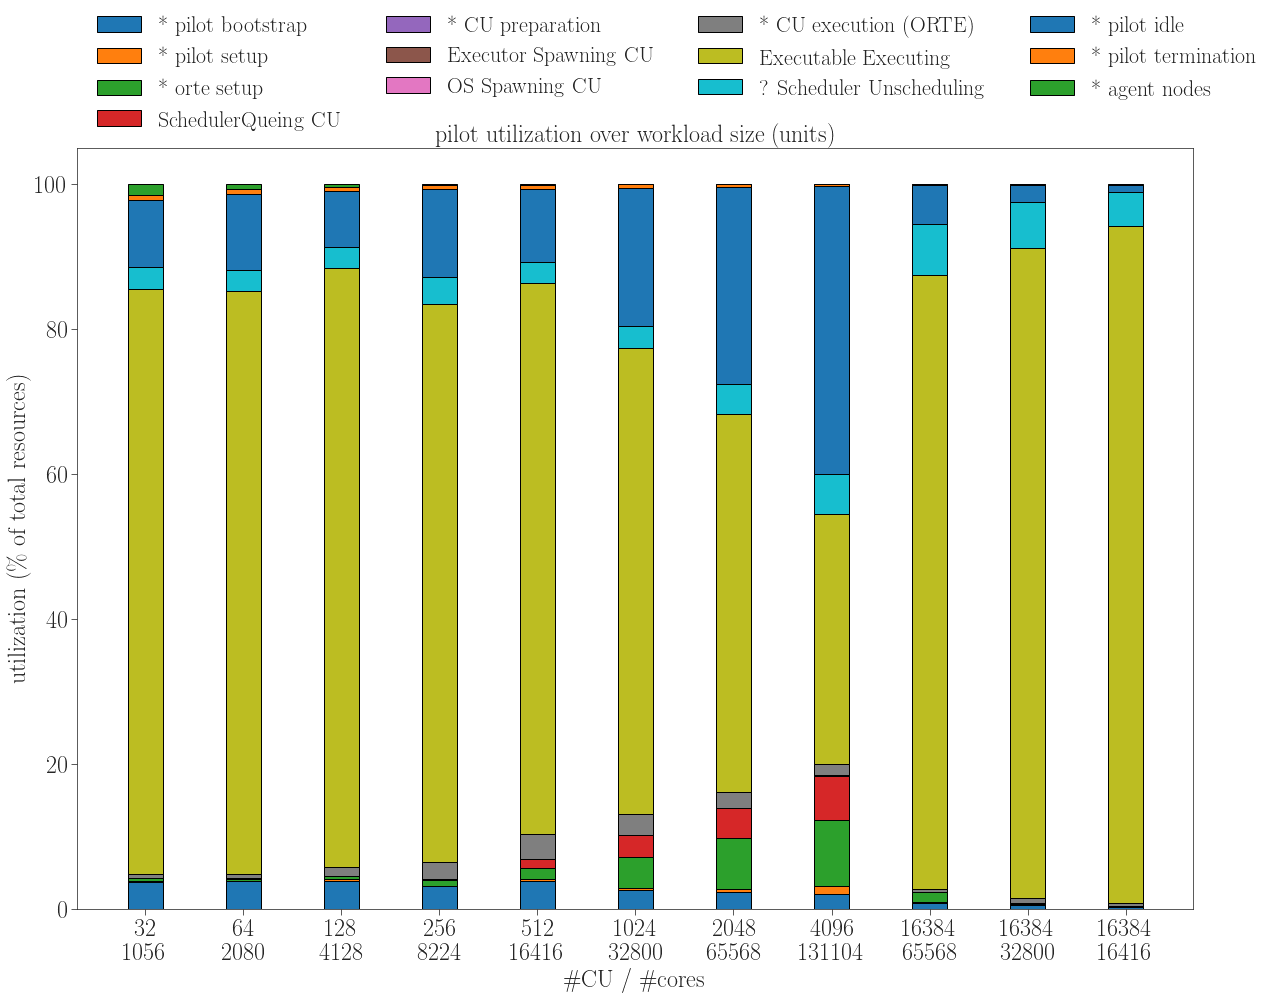

In [7]:
    # do the stacked barplots - yes, it is this cumbersome:
    # http://matplotlib.org/examples/pylab_examples/bar_stacked.html
    plt.figure(figsize=(20,14))
    bottom = np.zeros(len(xkeys))
    labels = list()
    plots  = list()
    ind    = np.arange(len(sids))  # locations for the bars on the x-axis
    width  = 0.35                  # width of the bars
    
    for key in ORDERED_KEYS:
        assert(len(data[key]) == len(ind))
        plots.append(plt.bar(ind, data[key], width, bottom=bottom))
        bottom += data[key]
        labels.append(TRANSLATE_KEYS[key])

    if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
    else       : plt.ylabel('utilization (in core-seconds)')

    plt.xlabel('\#CU / \#cores')
    plt.ylabel('utilization (\% of total resources)')
    plt.title ('pilot utilization over workload size (#units)')
    plt.xticks(ind, xkeys)
    handles = [p[0] for p in plots]
    plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0,1.2))
    plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')


In [7]:
import pprint
print data.keys()

data_sum_1 = dict()
for key in SUM_KEYS_1:
    print ' - %s' % key
    data_sum_1[key] = [0] * len(sids)
    for orig_key in SUM_KEYS_1[key]:
        print '   + %s' % orig_key
        for i in range(len(sids)):
            data_sum_1[key][i] += data[orig_key][i]

data_sum_2 = dict()
for key in SUM_KEYS_2:
    print ' - %s' % key
    data_sum_2[key] = [0] * len(sids)
    for orig_key in SUM_KEYS_2[key]:
        print '   + %s' % orig_key
        for i in range(len(sids)):
            data_sum_2[key][i] += data[orig_key][i]
            

['p_term', 'p_boot', 'u_equeue', 'p_agent', 'u_exec_orte', 'p_idle', 'u_exec_app', 'u_unschedule', 'u_exec_rp', 'p_orte', 'u_eprep', 'p_setup', 'u_exec_cu']
 - rp_scheduler
   + u_equeue
   + u_unschedule
 - rp_idle
   + p_idle
 - rp_overhead
   + p_agent
   + p_boot
   + p_setup
   + p_term
   + u_eprep
   + u_exec_rp
   + u_exec_cu
 - rp_orte
   + p_orte
   + u_exec_orte
 - rp_busy
   + u_exec_app
 - rp_idle
   + p_idle
 - rp_busy
   + u_exec_app
 - rp_overhead
   + p_agent
   + p_boot
   + p_setup
   + p_orte
   + p_term
   + u_equeue
   + u_eprep
   + u_exec_rp
   + u_exec_cu
   + u_exec_orte
   + u_unschedule


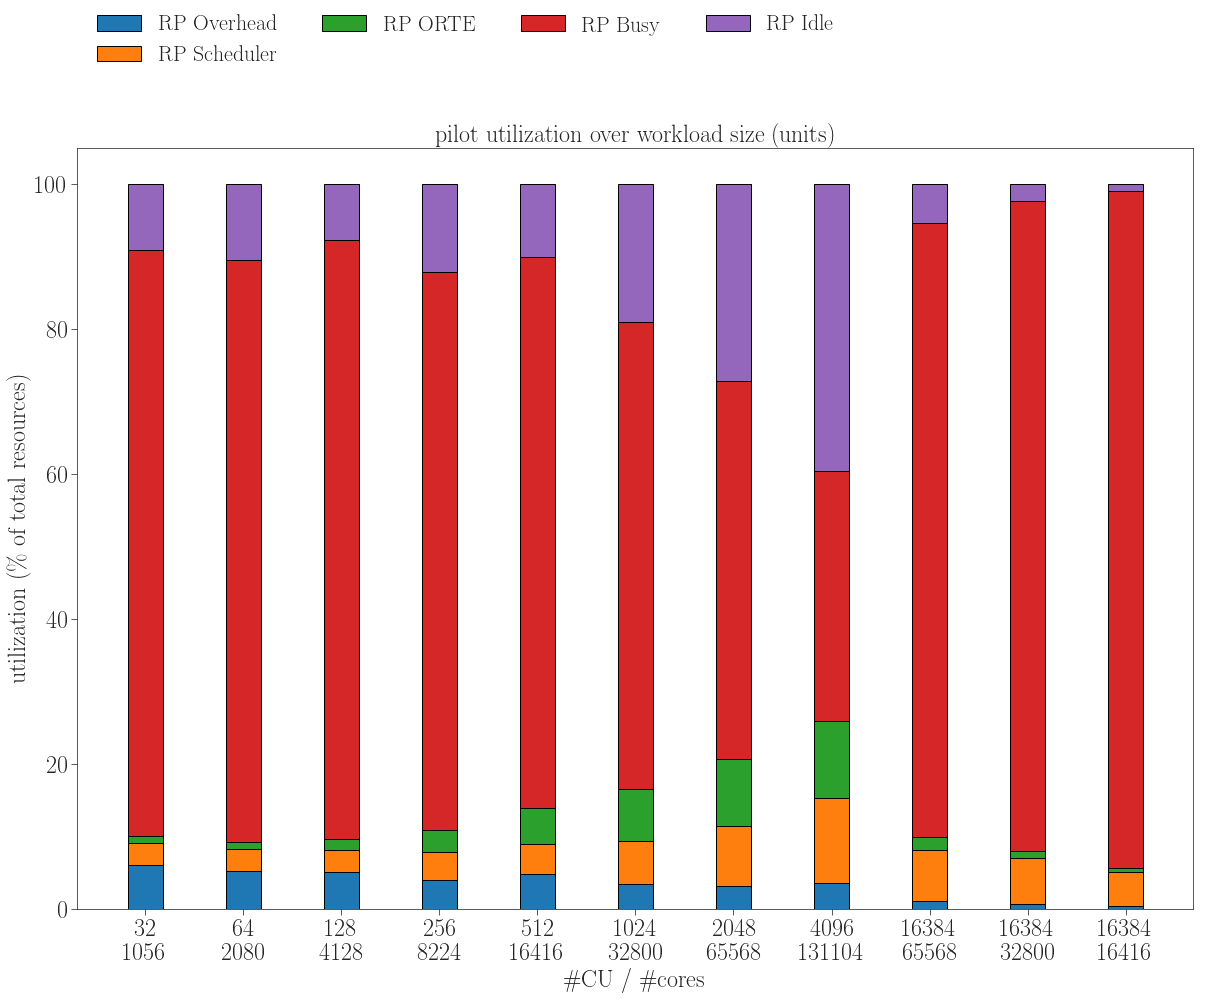

In [29]:
    # do the stacked barplots - yes, it is this cumbersome:
    # http://matplotlib.org/examples/pylab_examples/bar_stacked.html
    plt.figure(figsize=(20,14))
    bottom = np.zeros(len(xkeys))
    labels = list()
    plots  = list()
    ind    = np.arange(len(sids))  # locations for the bars on the x-axis
    width  = 0.35                  # width of the bars
    
    for key in ORDERED_KEYS_1:
        assert(len(data_sum_1[key]) == len(ind)), '%s != %s' % (len(data_sum_1[key]), len(ind))
        plots.append(plt.bar(ind, data_sum_1[key], width, bottom=bottom))
        bottom += data_sum_1[key]
        labels.append(TRANSLATE_KEYS[key])

    if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
    else       : plt.ylabel('utilization (in core-seconds)')

    plt.xlabel('\#CU / \#cores')
    plt.ylabel('utilization (\% of total resources)')
    plt.title ('pilot utilization over workload size (#units)')
    plt.xticks(ind, xkeys)
    handles = [p[0] for p in plots]
    plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0,1.2))
    plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')


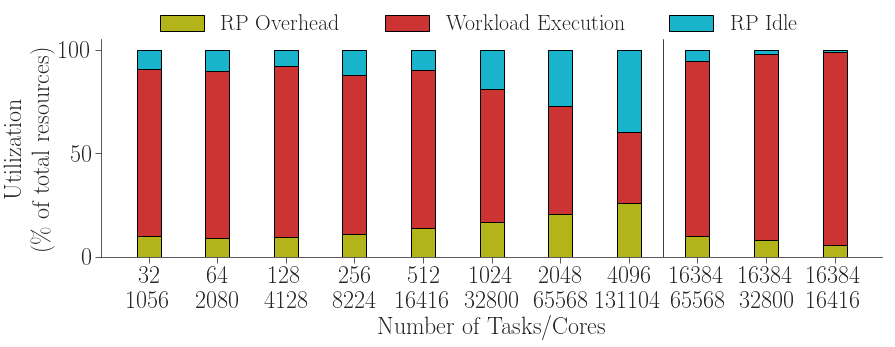

In [37]:
# do the stacked barplots - yes, it is this cumbersome:
# http://matplotlib.org/examples/pylab_examples/bar_stacked.html
plt.figure(figsize=(14,4))
plt.gca().set_color_cycle([tableau20[14],tableau20[6],tableau20[16]])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

bottom = np.zeros(len(xkeys))
labels = list()
plots  = list()
ind    = np.arange(len(sids))  # locations for the bars on the x-axis
width  = 0.35                  # width of the bars

for key in ORDERED_KEYS_2:
    assert(len(data_sum_2[key]) == len(ind)), '%s != %s' % (len(data_sum_2[key]), len(ind))
    plots.append(plt.bar(ind, data_sum_2[key], width, bottom=bottom))
    bottom += data_sum_2[key]
    labels.append(TRANSLATE_KEYS[key])

plt.axvline(x=7.5, color='black', linewidth=0.75)
    
plt.xlabel('Number of Tasks/Cores')
plt.ylabel('Utilization\n(\% of total resources)')
plt.xticks(ind, xkeys)

handles = [p[0] for p in plots]
plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0.05,1.2))

plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf', dpi=300, bbox_inches='tight')
